In [25]:
from openbb_terminal.sdk import openbb
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm




In [76]:
#fix this for SPY Equities data 
spy_data = openbb.etf.load("SPY", start_date = "2022-09-01", end_date = "2022-12-31", source = "YahooFinance")


Loading Daily data for SPY with starting period 2022-09-01.

In [77]:
spy_data.head

<bound method NDFrame.head of                   Open        High         Low       Close   Adj Close  \
date                                                                     
2022-09-01  385.218463  389.032491  382.424106  388.679535  388.679535   
2022-09-02  392.464197  393.719203  382.708468  384.581177  384.581177   
2022-09-06  385.453785  386.424445  380.835760  383.130066  383.130066   
2022-09-07  382.806510  390.807182  382.581020  390.013000  390.013000   
2022-09-08  387.669669  393.032834  386.424448  392.562225  392.562225   
...                ...         ...         ...         ...         ...   
2022-12-23  375.482411  378.854982  373.880200  378.706635  378.706635   
2022-12-27  378.587952  378.943985  375.482406  377.213196  377.213196   
2022-12-28  377.143956  379.181371  372.287882  372.525238  372.525238   
2022-12-29  375.462661  380.130849  374.918681  379.230835  379.230835   
2022-12-30  376.461605  378.380281  374.275843  378.231934  378.231934   

       

In [72]:
spy_options_data = pd.read_csv('/Users/eslifolkes/Downloads/SPY_OptionsChain_Q4_2022.csv', nrows=50000)  # loading a chunk of the dataset

# Convert implied volatility columns to numeric values, coercing errors
spy_options_data['__C_IV_'] = pd.to_numeric(spy_options_data['__C_IV_'], errors='coerce')
spy_options_data['__P_IV_'] = pd.to_numeric(spy_options_data['__P_IV_'], errors='coerce')

# Calculate the average implied volatility for both calls and puts
average_call_iv = spy_options_data['__C_IV_'].mean()
average_put_iv = spy_options_data['__P_IV_'].mean()

print(average_call_iv, average_put_iv)


0.31148646011893427 0.35538212998406754


In [90]:
# Parameters
notional = 1000000
vol_strike = 0.20
tenor = 3  # 3 months

# Given the S&P 500 data (assuming you have it loaded in a variable called sp500)
log_returns = np.diff(np.log(spy_data))
realized_vol = np.std(log_returns[-90*tenor:]) * np.sqrt(252)

# Calculate the variance swap payout
realized_variance = realized_vol**2
variance_payout = notional * (realized_variance - vol_strike**2)

# Evaluate the trade offered by the broker
# Adjusting the implied volatilities based on the broker's offer
adjusted_call_iv = average_call_iv - 0.01
adjusted_put_iv = average_put_iv - 0.01

# Vega exposure from the broker's trade (simplified computation)
vega_from_trade = notional * (adjusted_call_iv + adjusted_put_iv) / 2 * np.sqrt(tenor/12)

# Total Vega exposure (considering the variance swap and the broker's trade)
total_vega_exposure = vega_from_trade - notional  # Since you sold $1M of Vega notional in the variance swap

print(f"Vega Exposure from Broker's Trade: {vega_from_trade:.2f}")
print(f"Total Vega Exposure after considering Broker's Trade: {total_vega_exposure:.2f}")


Vega Exposure from Broker's Trade: 161717.15
Total Vega Exposure after considering Broker's Trade: -838282.85


In [85]:
missing_count = spy_data['Adj Close'].isnull().sum()

# Check for the number of zero values in the SPY data
zero_count = (spy_data['Adj Close'] == 0).sum()

print(f"Number of Missing Values: {missing_count}")
print(f"Number of Zero Values: {zero_count}")

# If there are no missing or zero values, compute log returns and realized volatility
if missing_count == 0 and zero_count == 0:
    log_returns = np.diff(np.log(spy_data['Adj Close']))
    realized_vol = np.std(log_returns[-90*tenor:]) * np.sqrt(252)

    # Calculate the variance swap payout
    realized_variance = realized_vol**2
    variance_payout = notional * (realized_variance - vol_strike**2)
else:
    realized_vol = np.nan
    variance_payout = np.nan

print(f"Realized Volatility: {realized_vol:.3f}")
print(f"Variance Swap Payout: ${variance_payout:.2f}")

# Vega exposure from the broker's trade (simplified computation)
vega_from_trade = notional * (adjusted_call_iv + adjusted_put_iv) / 2 * np.sqrt(tenor/12)

# Total Vega exposure (considering the variance swap and the broker's trade)
total_vega_exposure = vega_from_trade - notional  # Since you sold $1M of Vega notional in the variance swap

print(f"Vega Exposure from Broker's Trade: {vega_from_trade:.2f}")
print(f"Total Vega Exposure after considering Broker's Trade: {total_vega_exposure:.2f}")


Number of Missing Values: 0
Number of Zero Values: 0
Realized Volatility: 0.249
Variance Swap Payout: $21869.28
Vega Exposure from Broker's Trade: 161717.15
Total Vega Exposure after considering Broker's Trade: -838282.85


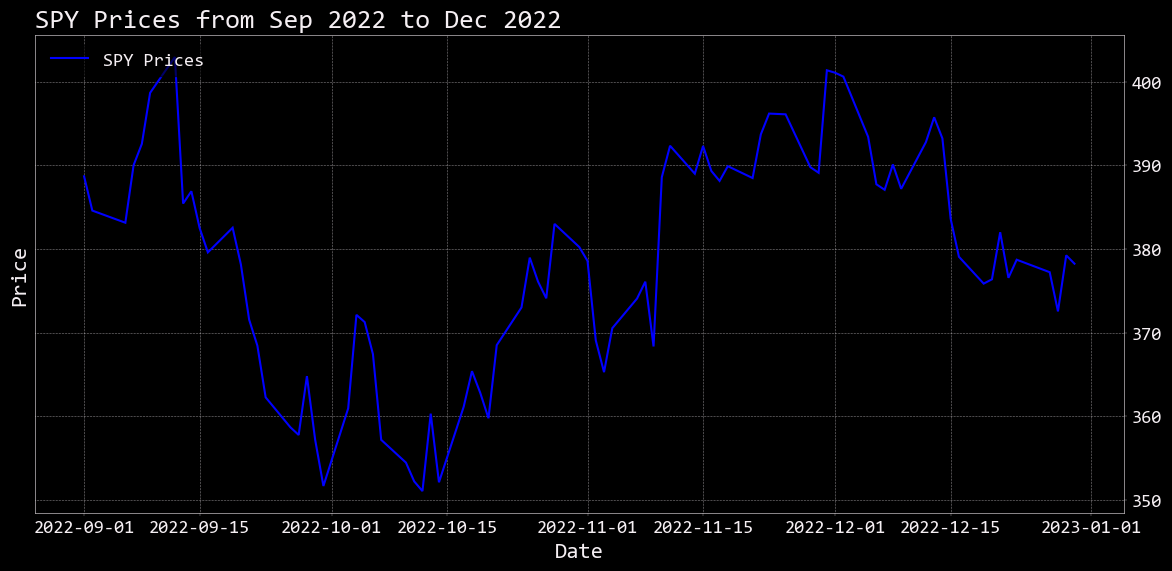

In [86]:
# Plot of SPY Prices
plt.figure(figsize=(12, 6))
plt.plot(spy_data['Adj Close'], color='blue', label='SPY Prices')
plt.title('SPY Prices from Sep 2022 to Dec 2022')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


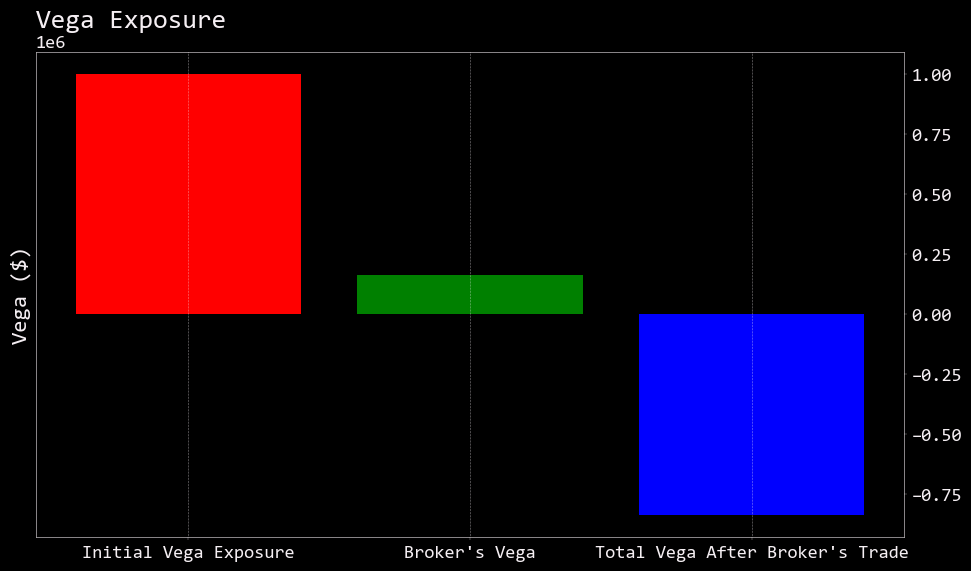

In [87]:
# Bar Chart of Vega Exposures
vega_values = [1000000, 161717.15, -838282.85]
vega_labels = ['Initial Vega Exposure', 'Broker\'s Vega', 'Total Vega After Broker\'s Trade']

plt.figure(figsize=(10, 6))
plt.bar(vega_labels, vega_values, color=['red', 'green', 'blue'])
plt.title('Vega Exposure')
plt.ylabel('Vega ($)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


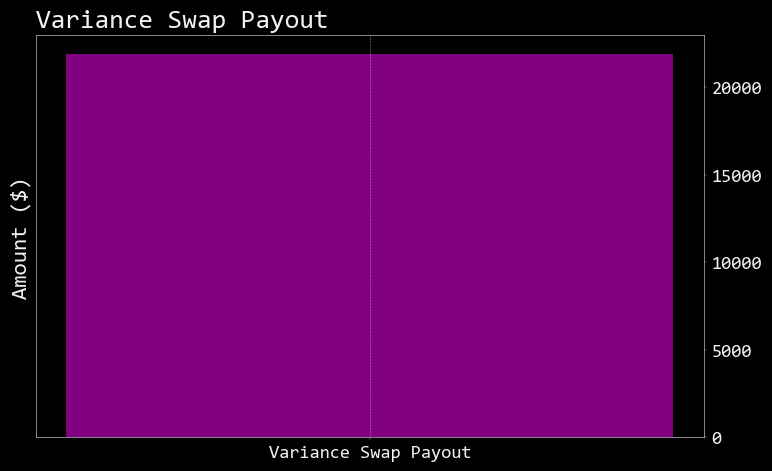

In [88]:
# Bar Chart of Variance Swap Payout
plt.figure(figsize=(8, 5))
plt.bar(['Variance Swap Payout'], [21869.28], color='purple')
plt.title('Variance Swap Payout')
plt.ylabel('Amount ($)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
